In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

# **Visualizing Classes**

In [9]:
train_dir = 'train/'
test_dir = 'test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [10]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<AxesSubplot:>

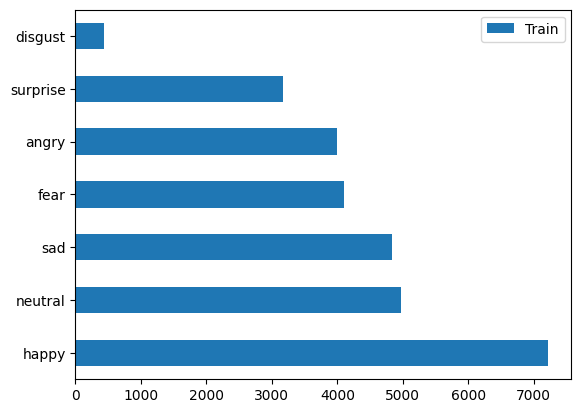

In [11]:
Train_Count.plot(kind='barh')

<AxesSubplot:>

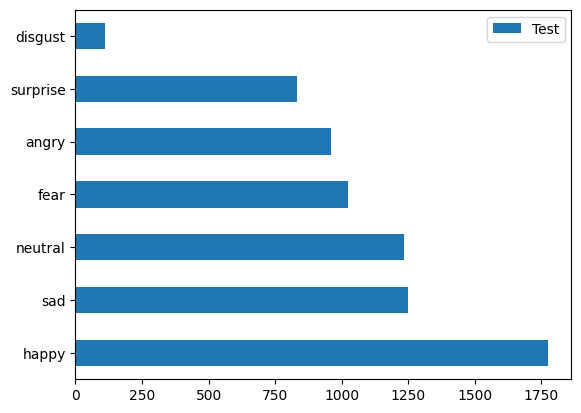

In [12]:
Test_Count.plot(kind='barh')

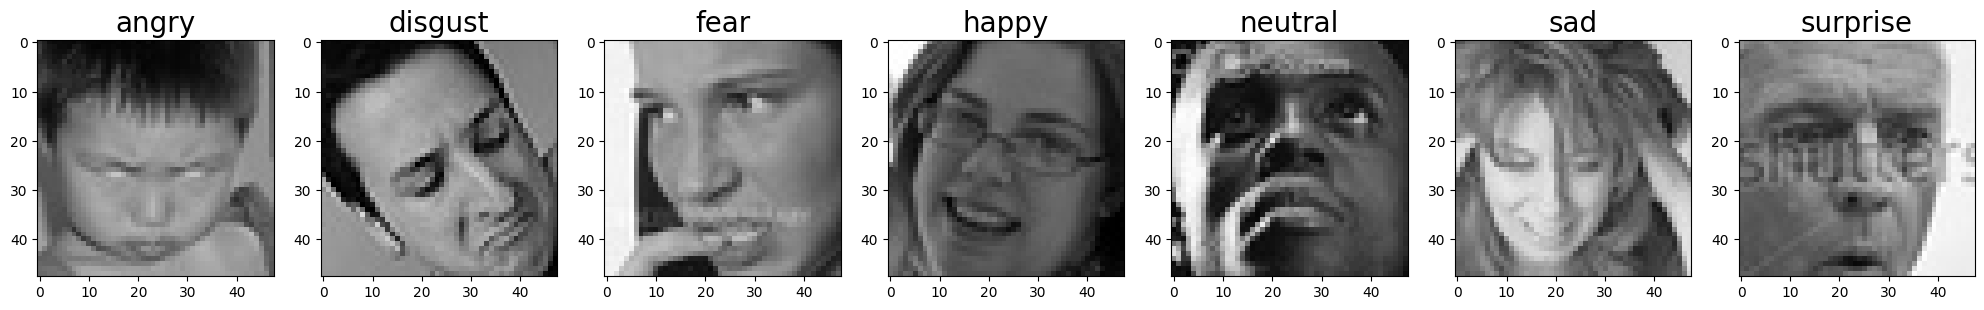

In [14]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = 'train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

In [18]:
img_shape = 48
batch_size = 64
train_data_path = 'train/'
test_data_path = 'test/'

In [19]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building CNN Model**

In [20]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [21]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                        

**Specifying Callbacks**

In [22]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [23]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50
448/448 [==============================] - 192s 423ms/step - loss: 2.0303 - accuracy: 0.2112 - val_loss: 1.8395 - val_accuracy: 0.2536 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 194s 432ms/step - loss: 1.7613 - accuracy: 0.2844 - val_loss: 1.7473 - val_accuracy: 0.3181 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 190s 425ms/step - loss: 1.6349 - accuracy: 0.3469 - val_loss: 1.6089 - val_accuracy: 0.3761 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 186s 415ms/step - loss: 1.5028 - accuracy: 0.4159 - val_loss: 1.4252 - val_accuracy: 0.4528 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 184s 410ms/step - loss: 1.4120 - accuracy: 0.4581 - val_loss: 1.2851 - val_accuracy: 0.5142 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 184s 410ms/step - loss: 1.3555 - accuracy: 0.4858 - val_loss: 1.2480 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 7/50
448/448 [==========================

# **Evaluating CNN Model**

In [24]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 9s 83ms/step - loss: 0.9032 - accuracy: 0.6694
    Test Loss: 0.90323
Test Accuracy: 66.94%


In [25]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

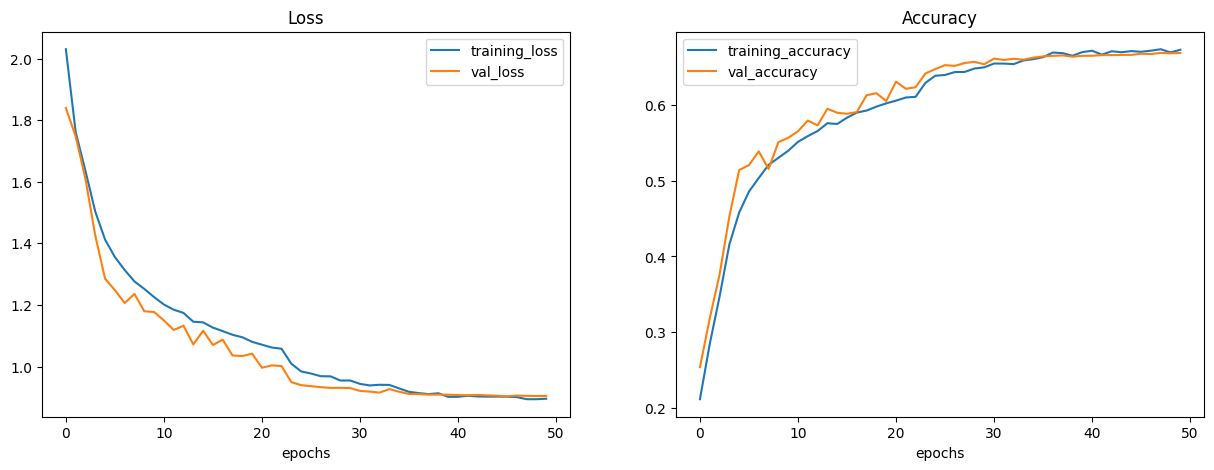

In [26]:
plot_curves(CNN_history)

In [27]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [28]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

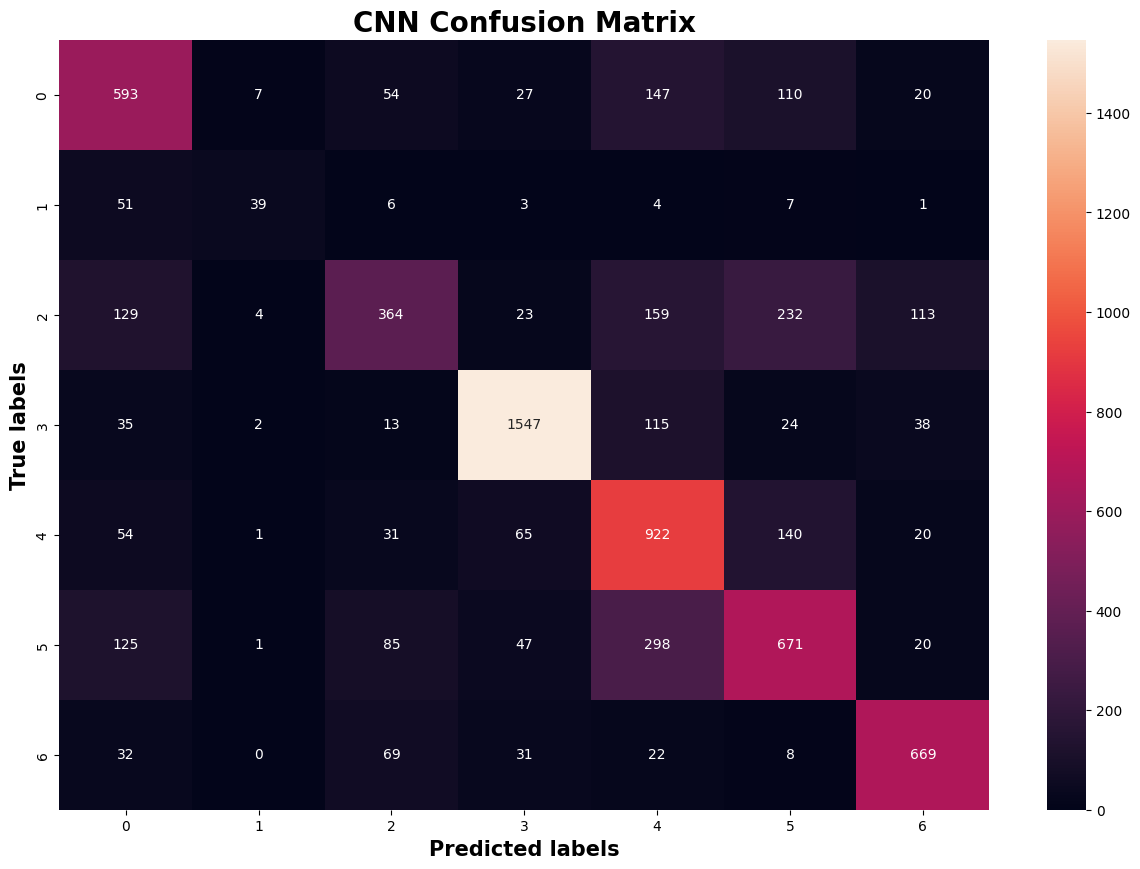

In [29]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# **ResNet50V2 Model**

In [32]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = 'train/'
test_data_path = 'test/'

In [34]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Fine-Tuning ResNet50V2**

In [35]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

94683136/94668760 [==============================] - 189s 2us/step


In [36]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [37]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [38]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 7, 7, 2048)       8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_13 (Bat  (None, 64)               256       
 chNormalization)                                     

**Specifying Callbacks**

In [39]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

# **Evaluating ResNet50V2**

In [41]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 192s 2s/step - loss: 1.1375 - accuracy: 0.5726
    Test Loss: 1.13748
Test Accuracy: 57.26%


In [43]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

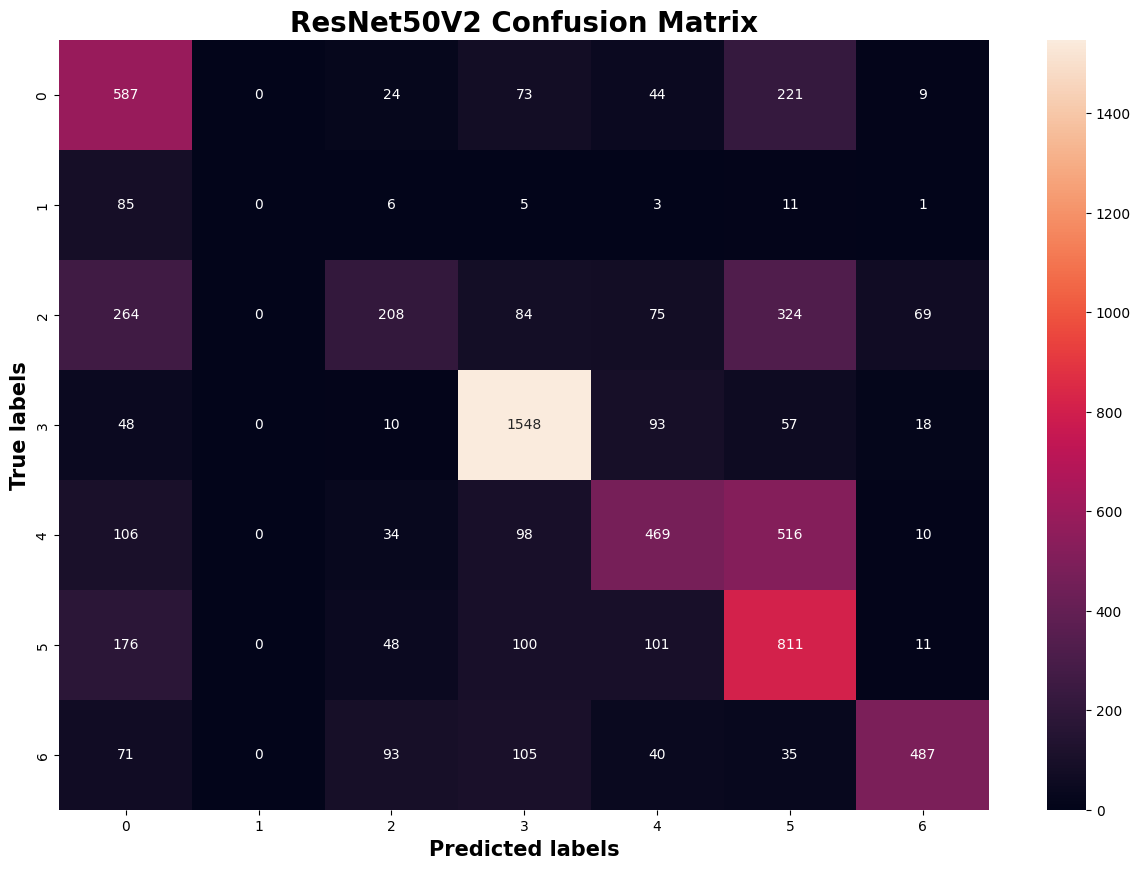

In [44]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [45]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [46]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**CNN Predictions**

ValueError: in user code:

    File "c:\Users\hariv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\hariv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\hariv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\hariv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\hariv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\hariv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 48, 48, 3), found shape=(None, 224, 224, 3)


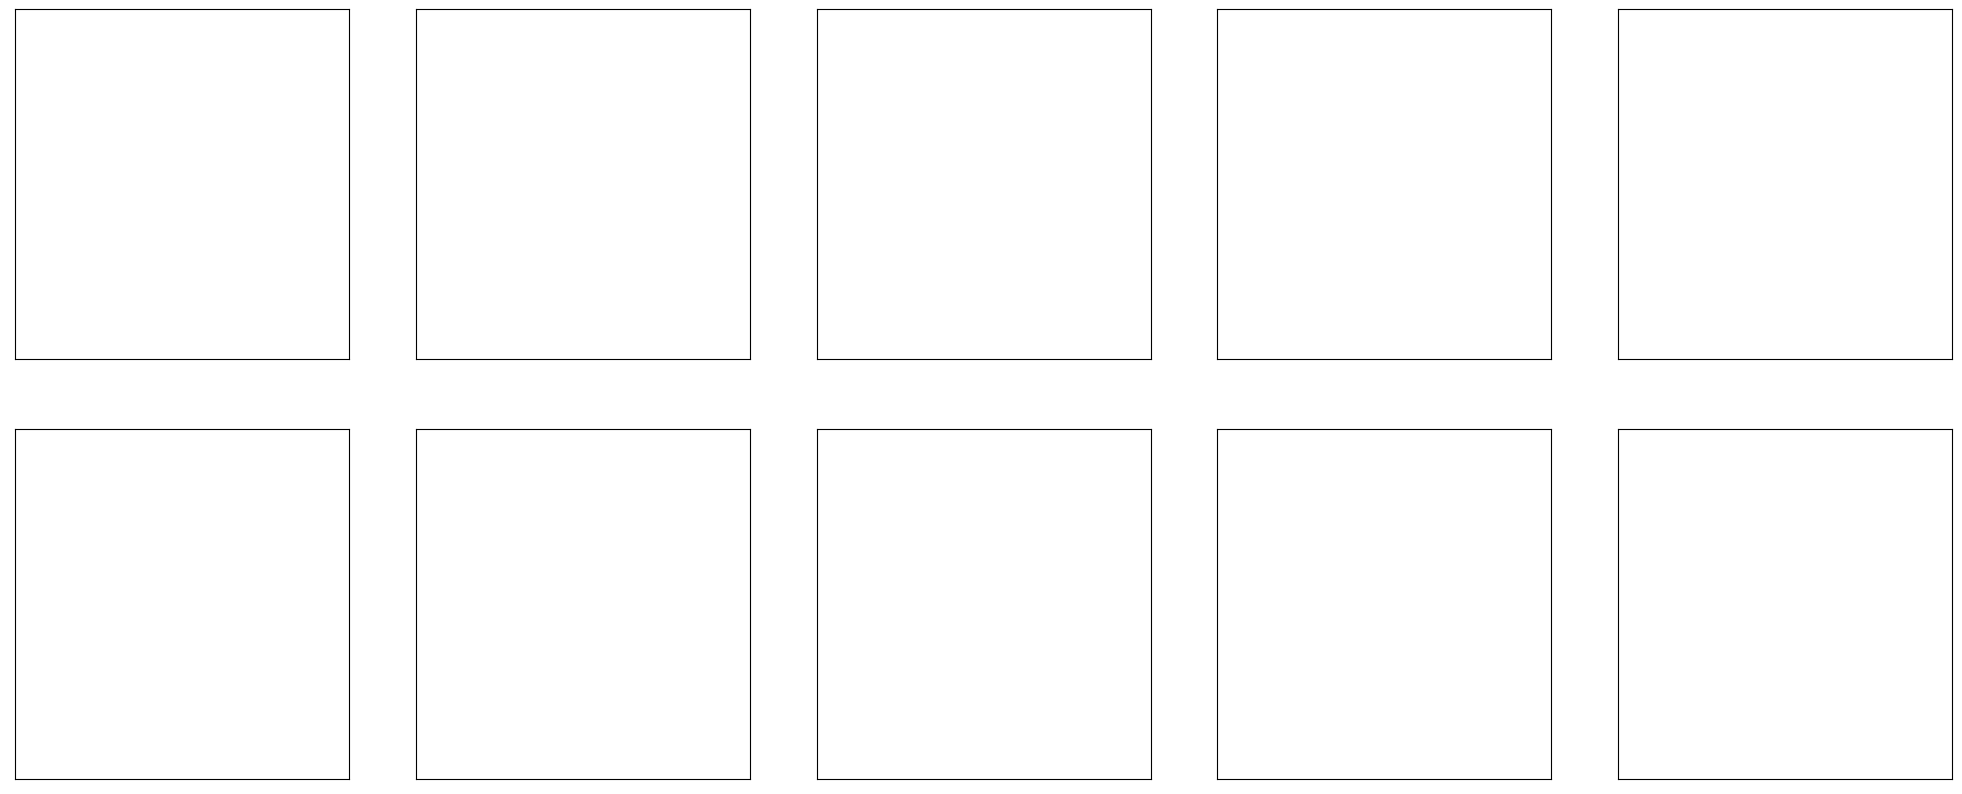

In [51]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

**ResNet50V2 Predictions**

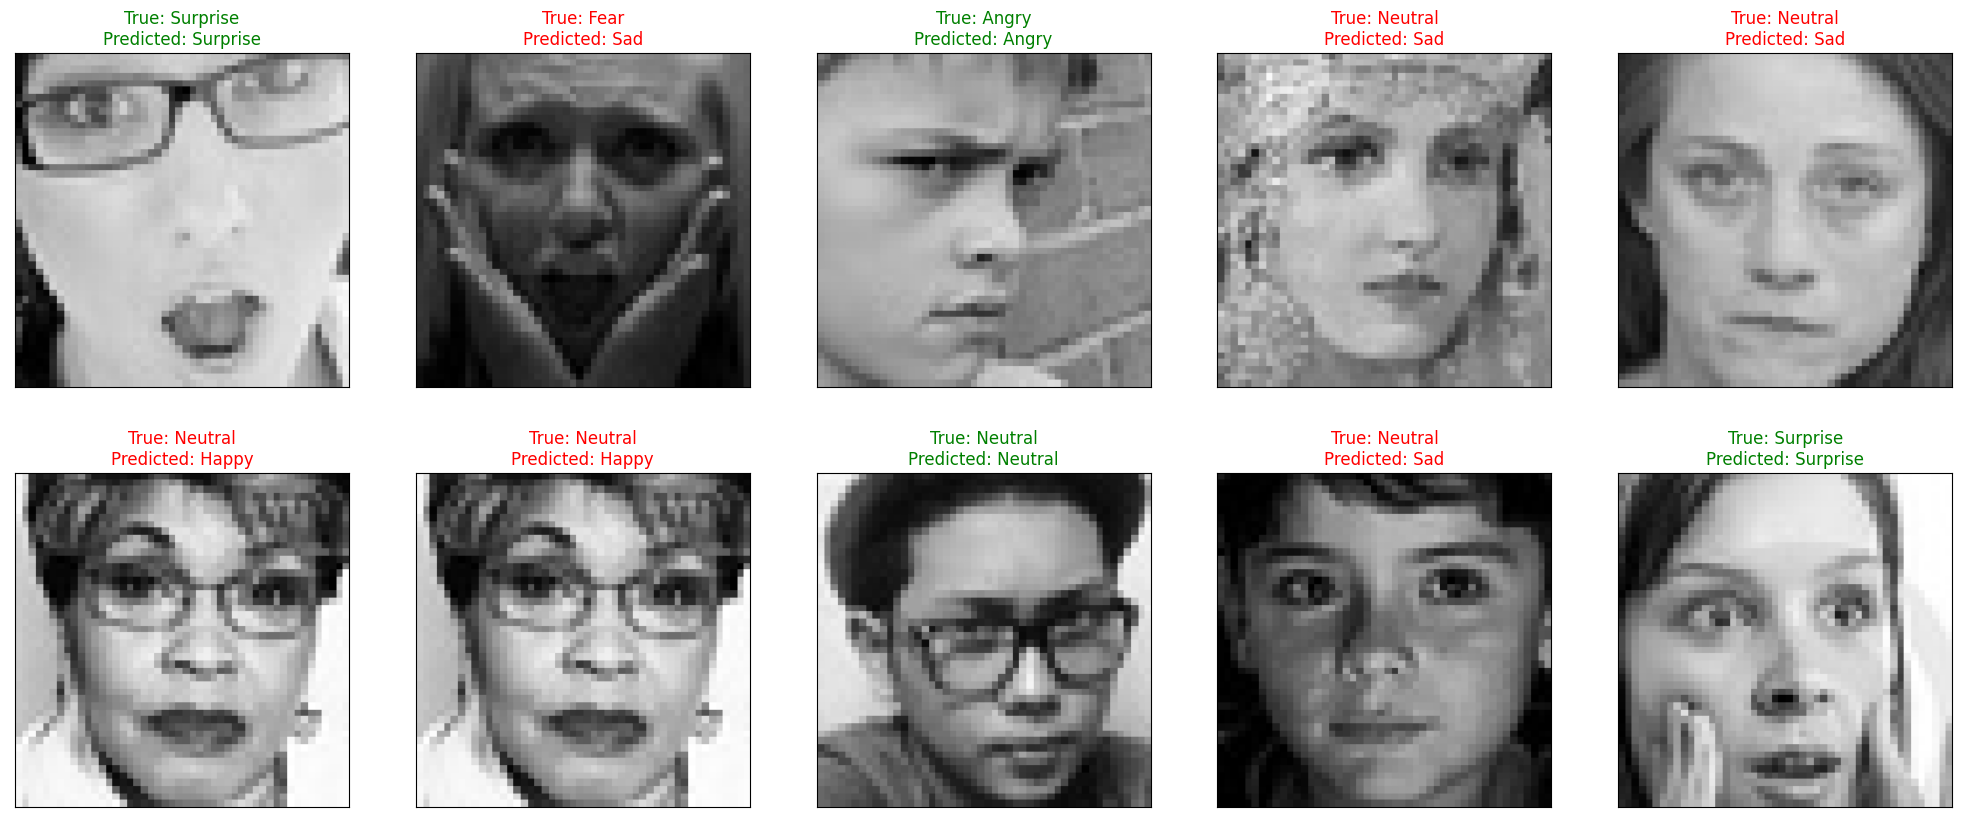

<Figure size 640x480 with 0 Axes>

In [50]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [92]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [93]:
def load_and_prep_image(filename, img_shape = 224):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [94]:
def pred_and_plot(filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    # Plot the image and predicted class
    #plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
    

In [95]:
pred_and_plot("test/sad/PrivateTest_13472479.jpg", Emotion_Classes) # with CNN

error: OpenCV(4.5.3) D:\Build\OpenCV\opencv-4.5.3\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [96]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg" -O sad.jpg

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [97]:
pred_and_plot("./happy.jpg", Emotion_Classes) # with CNN

error: OpenCV(4.5.3) D:\Build\OpenCV\opencv-4.5.3\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


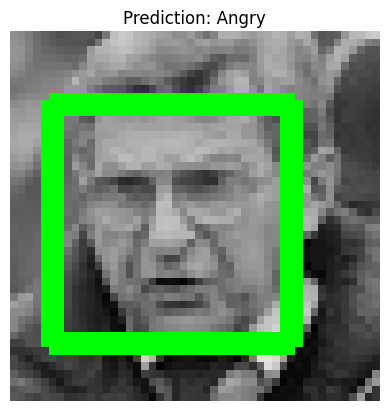

In [ ]:
pred_and_plot("../input/fer2013/test/angry/PrivateTest_22126718.jpg", Emotion_Classes) # with ResNet50V2

In [ ]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/profile_images/758370732413947904/xYB5Q3FY_400x400.jpg" -O happy.jpg 

,name,artist,mood,popularity
0,lovely (with Khalid),Billie Eilish,Sad,88
1,you broke me first,Tate McRae,Sad,87
2,when the party's over,Billie Eilish,Sad,87
3,Falling,Harry Styles,Sad,87
4,Before You Go,Lewis Capaldi,Sad,85


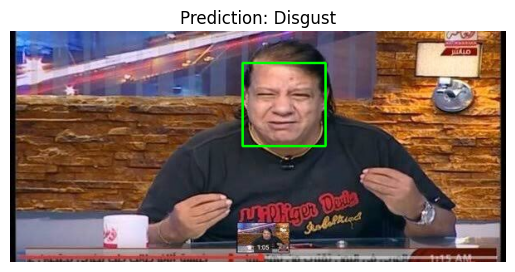

In [ ]:
pred_and_plot("./sad.jpg", Emotion_Classes) # with ResNet50V2

In [ ]:
CNN_Model.save("CNN_Model.h5")

ResNet50V2_Model.save("ResNet50V2_Model.h5")